# Práctica 3: Comparación de Clasificadores con Reducción de Dimensionalidad

**Fundamentos del Aprendizaje Automático - Curso 2025-2026**

Este notebook implementa:
1. **Reducción de dimensionalidad**: PCA (≥60% varianza) y Autoencoder neuronal (mitad de features)
2. **Clasificadores**: k-NN y Perceptrón Multicapa (MLP)
3. **Evaluación**: Validación cruzada 5-fold estratificada
4. **Análisis estadístico**: Test de Wilcoxon para comparar métodos

---

## 1. Importación de Librerías

In [15]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Estadística
from scipy.stats import wilcoxon

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning if 'ConvergenceWarning' in dir() else UserWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 80)
print("✓ Librerías importadas correctamente")
print("=" * 80)

✓ Librerías importadas correctamente


## 2. Configuración de Rutas y Parámetros

In [16]:
# ============================================================================
# 2. CONFIGURACIÓN DE RUTAS Y PARÁMETROS
# ============================================================================

# Rutas base
BASE_PATH = Path('./data')
ORIGINAL_PATH = BASE_PATH / 'original'
PCA_PATH = BASE_PATH / 'pca'
AUTOENCODER_PATH = BASE_PATH / 'autoencoder'

# Crear directorios si no existen
PCA_PATH.mkdir(parents=True, exist_ok=True)
AUTOENCODER_PATH.mkdir(parents=True, exist_ok=True)

# Parámetros de validación cruzada
N_SPLITS = 5
P_VALOR_THRESHOLD = 0.05

# Parámetros de PCA
PCA_MIN_VARIANCE = 0.60  

# Parámetros del Autoencoder
AE_ACTIVATIONS = ['relu', 'tanh']
AE_MAX_ITERS = [500, 1000]
AE_HIDDEN_SIZES = [(64, 32), (128, 64)]

# Parámetros de k-NN
KNN_K_VALUES = [1, 3, 5, 7, 9, 11]

# Parámetros del MLP Classifier
MLP_HIDDEN_SIZES = [(50,), (100,), (50, 25), (100, 50)]
MLP_ACTIVATIONS = ['relu', 'tanh']
MLP_MAX_ITERS = [500, 1000]

print("=" * 80)
print("CONFIGURACIÓN")
print("=" * 80)
print(f"\n📁 Rutas:")
print(f"   Original:    {ORIGINAL_PATH}")
print(f"   PCA:         {PCA_PATH}")
print(f"   Autoencoder: {AUTOENCODER_PATH}")
print(f"\n📊 Validación Cruzada: {N_SPLITS}-fold estratificada")
print(f"📏 PCA: mínimo {PCA_MIN_VARIANCE*100:.0f}% de varianza acumulada")
print(f"🎯 p-valor threshold: {P_VALOR_THRESHOLD}")
print("=" * 80)

CONFIGURACIÓN

📁 Rutas:
   Original:    data\original
   PCA:         data\pca
   Autoencoder: data\autoencoder

📊 Validación Cruzada: 5-fold estratificada
📏 PCA: mínimo 60% de varianza acumulada
🎯 p-valor threshold: 0.05


## 3. Funciones Auxiliares para Carga y Procesamiento de Datos

In [17]:
# ============================================================================
# 3. FUNCIONES AUXILIARES
# ============================================================================

def _find_column_by_lower(df, target_lower):
    for c in df.columns:
        if c.lower() == target_lower:
            return c
    return None


def _move_col_to_end(df, col):
    if col not in df.columns:
        return df
    cols = [c for c in df.columns if c != col] + [col]
    return df[cols]


def prepare_dataset_df(df, dataset_name):
    """
    Prepara el DataFrame para asegurar una columna objetivo estándar llamada 'class'.

    Reglas:
    - Si ya existe 'class', no hace nada.
    - Si es Spotify y existe 'Popularity', crea 'class' en 3 niveles (baja/media/alta).
    - Si hay otra columna objetivo conocida (type, occupancy_class, ...), copia a 'class'.

    Retorna (df_mod, info) donde info incluye exclude_cols_extra si aplica (p.ej. Popularity).
    """
    info = {'created_class': False, 'class_source': None, 'exclude_cols_extra': []}
    ds = str(dataset_name).lower()

    if 'class' in df.columns:
        return _move_col_to_end(df, 'class'), info

    # Caso específico: Spotify -> discretizar Popularity en baja/media/alta
    if 'spotify' in ds:
        popularity_col = _find_column_by_lower(df, 'popularity')
        if popularity_col is not None:
            s = pd.to_numeric(df[popularity_col], errors='coerce')
            if s.notna().sum() == 0:
                raise ValueError("Spotify: 'Popularity' no es numérica; no puedo crear 'class'.")

            # Intentar terciles (aprox. balanceado). Si hay muchos repetidos, qcut puede bajar bins.
            try:
                y_class = pd.qcut(s, q=3, labels=['baja', 'media', 'alta'], duplicates='drop')
                if len(getattr(y_class, 'cat', y_class).categories) != 3:
                    raise ValueError("qcut no pudo crear 3 bins")
            except Exception:
                y_class = pd.cut(s, bins=3, labels=['baja', 'media', 'alta'])

            df = df.copy()
            df['class'] = y_class.astype(str)
            df = _move_col_to_end(df, 'class')

            info['created_class'] = True
            info['class_source'] = popularity_col
            info['exclude_cols_extra'] = [popularity_col]  # evitar leakage
            return df, info

    # Si existe alguna columna objetivo conocida, copiar a 'class'
    candidate_targets = [
        'occupancy_class', 'type', 'label', 'target', 'category', 'quarter'
    ]
    lower_cols = {c.lower(): c for c in df.columns}
    for cand in candidate_targets:
        if cand in lower_cols:
            src = lower_cols[cand]
            df = df.copy()
            df['class'] = df[src]
            df = _move_col_to_end(df, 'class')
            info['created_class'] = True
            info['class_source'] = src
            return df, info

    # No se pudo inferir automáticamente
    return df, info


def detect_dataset_config(df, dataset_name, extra_exclude_cols=None):
    """
    Detecta automáticamente la configuración del dataset:
    - Columnas de features
    - Columna de clase
    - Columnas a excluir (nombres, IDs, fechas)
    """
    if extra_exclude_cols is None:
        extra_exclude_cols = []

    ds = str(dataset_name).lower()

    # Columnas comunes de clase (en orden de prioridad)
    class_cols = ['class', 'type', 'label', 'target', 'occupancy_class', 'category', 'quarter']
    # Columnas a excluir (identificadores, fechas)
    exclude_patterns = ['name', 'id', 'date', 'animal', 'code']

    # Evitar fuga de etiqueta en Spotify: si 'Popularity' se usó/puede usarse como clase, no debe ser feature
    if 'spotify' in ds:
        exclude_patterns.append('popularity')

    # Detectar columna de clase
    class_col = None
    df_cols_lower = df.columns.str.lower().tolist()
    for col in class_cols:
        if col in df_cols_lower:
            idx = df_cols_lower.index(col)
            class_col = df.columns[idx]
            break

    if class_col is None:
        # Usar última columna como clase si no se detecta
        class_col = df.columns[-1]
        print(f"   ⚠️ Clase no detectada, usando última columna: '{class_col}'")

    # Detectar columnas a excluir
    exclude_cols = [class_col] + list(extra_exclude_cols)
    for col in df.columns:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in exclude_patterns):
            exclude_cols.append(col)
        # Excluir columnas de tipo fecha
        if df[col].dtype == 'object':
            try:
                pd.to_datetime(df[col])
                exclude_cols.append(col)
            except:
                pass

    # Excluir columnas que no sean numéricas (excepto la clase)
    for col in df.columns:
        if col not in exclude_cols and df[col].dtype == 'object' and col != class_col:
            exclude_cols.append(col)

    exclude_cols = list(set(exclude_cols))
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    # Filtrar solo columnas numéricas
    numeric_feature_cols = []
    for col in feature_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_feature_cols.append(col)

    return {
        'class_col': class_col,
        'feature_cols': numeric_feature_cols,
        'exclude_cols': exclude_cols
    }


def ensure_class_column_in_file(file_path, dataset_name, class_values=None):
    """
    Asegura que el CSV tiene una columna 'class' al final.

    - Si no existe y class_values se pasa, la añade (verificando longitud).
    - Si no existe y class_values es None, intenta inferirla con prepare_dataset_df.
    - Si existe, la mueve al final.

    Retorna (df, info) donde info incluye si se modificó el archivo.
    """
    df = pd.read_csv(file_path)
    info = {'modified': False, 'created_class': False, 'class_source': None, 'exclude_cols_extra': []}

    if 'class' not in df.columns:
        if class_values is not None:
            if len(class_values) != len(df):
                raise ValueError(f"Longitud de class_values ({len(class_values)}) != filas ({len(df)}) en {file_path}")
            df['class'] = list(class_values)
            info['modified'] = True
            info['created_class'] = True
            info['class_source'] = 'provided'
        else:
            df2, prep = prepare_dataset_df(df, dataset_name)
            if 'class' not in df2.columns:
                raise ValueError(f"No se pudo inferir 'class' para {dataset_name} en {file_path}")
            df = df2
            info['modified'] = True
            info['created_class'] = prep.get('created_class', False)
            info['class_source'] = prep.get('class_source', None)
            info['exclude_cols_extra'] = prep.get('exclude_cols_extra', [])

    # Mover al final si no lo está
    if df.columns[-1] != 'class':
        df = _move_col_to_end(df, 'class')
        info['modified'] = True

    if info['modified']:
        df.to_csv(file_path, index=False)

    return df, info


def load_dataset(file_path, dataset_name):
    """
    Carga un dataset y retorna X (features) e y (etiquetas).

    Nota: si el CSV no tiene columna 'class', se intenta crear en memoria (sin guardar).
    """
    df = pd.read_csv(file_path)
    df, prep = prepare_dataset_df(df, dataset_name)
    config = detect_dataset_config(df, dataset_name, extra_exclude_cols=prep.get('exclude_cols_extra', []))

    X = df[config['feature_cols']].copy()
    y_raw = df[config['class_col']].copy()

    # Codificar etiquetas si es necesario
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_raw)

    print(f"\n📊 Dataset: {dataset_name}")
    print(f"   Features: {len(config['feature_cols'])} columnas")
    print(f"   Clase: '{config['class_col']}' ({len(le.classes_)} clases)")
    print(f"   Muestras: {len(X)}")
    print(f"   Clases: {list(le.classes_)[:5]}..." if len(le.classes_) > 5 else f"   Clases: {list(le.classes_)}")

    return X, y_encoded, y_raw, le, config


def get_dataset_name(file_path):
    """Extrae el nombre base del dataset desde la ruta del archivo."""
    return Path(file_path).stem.replace('_pca', '').replace('_autoencoder', '')


def discover_datasets():
    """
    Descubre automáticamente todos los datasets disponibles en las carpetas.
    Retorna un diccionario con la estructura de datasets.
    """
    datasets = {}

    # Buscar archivos originales
    for file_path in ORIGINAL_PATH.glob('*.csv'):
        name = file_path.stem
        datasets[name] = {
            'original': file_path,
            'pca': PCA_PATH / f'{name}_pca.csv',
            'autoencoder': AUTOENCODER_PATH / f'{name}_autoencoder.csv'
        }

    return datasets

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


In [18]:
# ============================================================================
# CORRECCIÓN PREVIA DE DATASETS (SOLICITUD USUARIO)
# ============================================================================

print("=" * 80)
print("🛠️ CORRECCIÓN Y FORMATEO DE DATASETS")
print("=" * 80)

for file_path in ORIGINAL_PATH.glob('*.csv'):
    name = file_path.stem
    df = pd.read_csv(file_path)
    modified = False
    
    # 1. Normalizar nombre de columna 'class' (Class -> class)
    # Buscar si existe alguna variante de case (Class, CLASS, etc.)
    for col in df.columns:
        if col.lower() == 'class' and col != 'class':
            df.rename(columns={col: 'class'}, inplace=True)
            print(f"   ✅ {name}: Renombrada columna '{col}' a 'class'")
            modified = True
            break
            
    # 2. Caso específico Cinema: eliminar duplicado
    if name == 'cinema':
        if 'occupancy_class' in df.columns and 'class' in df.columns:
            df.drop(columns=['occupancy_class'], inplace=True)
            print(f"   ✅ {name}: Eliminada columna redundante 'occupancy_class'")
            modified = True
    
    # 3. Mover 'class' al final si existe
    if 'class' in df.columns:
        cols = [c for c in df.columns if c != 'class'] + ['class']
        if list(df.columns) != cols:
            df = df[cols]
            print(f"   ✅ {name}: Columna 'class' movida al final")
            modified = True
            
    if modified:
        df.to_csv(file_path, index=False)
        print(f"   💾 {name}: Archivo actualizado")
    else:
        print(f"   👌 {name}: Estructura correcta")

print("=" * 80)

🛠️ CORRECCIÓN Y FORMATEO DE DATASETS
   👌 breast_tissue: Estructura correcta
   👌 cinema: Estructura correcta
   👌 spotify: Estructura correcta
   👌 wine: Estructura correcta
   👌 zoo: Estructura correcta


## 4. Generación de Versiones PCA y Autoencoder

### T1: Reducción de Dimensionalidad
- **PCA**: Reducción con al menos 60% de varianza acumulada
- **Autoencoder**: Reducción a la mitad de características usando `MLPRegressor`

In [19]:
# ============================================================================
# 4.1 FUNCIÓN PARA APLICAR PCA
# ============================================================================

def apply_pca(X, dataset_name, min_variance=0.60):
    """
    Aplica PCA manteniendo al menos min_variance de varianza acumulada.
    """
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Primero ajustamos PCA completo para ver varianza explicada
    pca_full = PCA(random_state=RANDOM_STATE)
    pca_full.fit(X_scaled)
    
    # Encontrar número mínimo de componentes para alcanzar varianza objetivo
    cumsum = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= min_variance) + 1
    
    # Asegurar al menos 2 componentes
    n_components = max(2, n_components)
    
    # Aplicar PCA con los componentes seleccionados
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)
    
    variance_explained = np.sum(pca.explained_variance_ratio_)
    
    print(f"\n🔷 PCA para '{dataset_name}':")
    print(f"   Features originales: {X.shape[1]}")
    print(f"   Componentes PCA: {n_components}")
    print(f"   Varianza explicada: {variance_explained*100:.2f}%")
    
    # Crear DataFrame con nombres de columnas
    cols = [f'PCA_{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca, columns=cols)
    
    return df_pca, pca, scaler


# ============================================================================
# 4.2 FUNCIÓN PARA APLICAR AUTOENCODER
# ============================================================================

def apply_autoencoder(X, dataset_name, target_dim=None):
    """
    Aplica un autoencoder neuronal para reducir dimensionalidad.
    El espacio latente (bottleneck) tiene la mitad de las features originales.
    """
    if target_dim is None:
        target_dim = max(2, X.shape[1] // 2)  # Mitad de features, mínimo 2
    
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Arquitectura del autoencoder: encoder -> bottleneck -> decoder
    # Usamos MLPRegressor para reconstruir la entrada
    input_dim = X.shape[1]
    
    # Capas: input -> hidden -> bottleneck -> hidden -> output
    # Para extraer el bottleneck, entrenamos el autoencoder completo
    # y luego usamos solo la primera mitad (encoder)
    
    # Arquitectura simétrica
    encoder_dim = max(target_dim * 2, input_dim // 2)
    hidden_layers = (encoder_dim, target_dim, encoder_dim)
    
    print(f"\n🔶 Autoencoder para '{dataset_name}':")
    print(f"   Features originales: {input_dim}")
    print(f"   Dimensión latente objetivo: {target_dim}")
    print(f"   Arquitectura: {input_dim} → {encoder_dim} → {target_dim} → {encoder_dim} → {input_dim}")
    
    # Entrenar autoencoder
    # CAMBIO: Usamos 'tanh' en lugar de 'relu' para evitar "muerte de neuronas" (ceros)
    # en datasets pequeños o con distribuciones difíciles.
    autoencoder = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        activation='tanh', 
        solver='adam',
        max_iter=2000, # Aumentamos iteraciones
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        verbose=False
    )
    
    autoencoder.fit(X_scaled, X_scaled)
    
    # Extraer representación del bottleneck
    # Propagamos hacia adelante hasta la capa del bottleneck
    X_encoded = X_scaled.copy()
    
    # Aplicar capas del encoder (solo hasta el bottleneck)
    n_encoder_layers = len(hidden_layers) // 2 + 1  # Hasta la capa central
    
    for i in range(n_encoder_layers):
        W = autoencoder.coefs_[i]
        b = autoencoder.intercepts_[i]
        X_encoded = np.dot(X_encoded, W) + b
        # Aplicar activación Tanh (coherente con el modelo)
        X_encoded = np.tanh(X_encoded)
    
    # Calcular error de reconstrucción
    X_reconstructed = autoencoder.predict(X_scaled)
    reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)
    
    print(f"   Error de reconstrucción (MSE): {reconstruction_error:.6f}")
    print(f"   Dimensión del encoding: {X_encoded.shape[1]}")
    
    # Crear DataFrame con nombres de columnas
    cols = [f'AE_{i+1}' for i in range(X_encoded.shape[1])]
    df_ae = pd.DataFrame(X_encoded, columns=cols)
    
    return df_ae, autoencoder, scaler

print("✓ Funciones de reducción de dimensionalidad definidas (Autoencoder actualizado a Tanh)")

✓ Funciones de reducción de dimensionalidad definidas (Autoencoder actualizado a Tanh)


In [20]:
# ============================================================================
# 4.3 GENERAR VERSIONES PCA Y AUTOENCODER PARA TODOS LOS DATASETS
#     + asegurar columna 'class' en TODOS los CSV
# ============================================================================

print("=" * 80)
print("GENERACIÓN DE VERSIONES REDUCIDAS DE LOS DATASETS")
print("=" * 80)

# Descubrir datasets disponibles
datasets_info = discover_datasets()
print(f"\n📁 Datasets encontrados: {list(datasets_info.keys())}")

# Para cada dataset, generar PCA y Autoencoder si no existen
for name, paths in datasets_info.items():
    print(f"\n{'='*60}")
    print(f"Procesando: {name.upper()}")
    print(f"{'='*60}")
    
    # 1) Asegurar que el ORIGINAL tiene columna 'class' al final
    df_orig, orig_info = ensure_class_column_in_file(paths['original'], name)
    if orig_info['created_class']:
        print(f"   ✅ Añadida 'class' en ORIGINAL (origen: {orig_info['class_source']})")
    elif orig_info['modified']:
        print(f"   ✅ Reordenada 'class' al final en ORIGINAL")
    
    # 2) Cargar dataset original (X,y) para construir reducciones
    X, y, y_raw, le, config = load_dataset(paths['original'], name)
    class_values = df_orig['class'].values if 'class' in df_orig.columns else y_raw.values
    
    # 3) PCA: generar o cargar, pero SIEMPRE asegurar 'class' en el CSV
    force_regen_pca = False
    if paths['pca'].exists():
        df_check = pd.read_csv(paths['pca'])
        # Detectar corrupción: Class y class duplicadas
        if 'Class' in df_check.columns and 'class' in df_check.columns:
            force_regen_pca = True
            print(f"   ⚠️ PCA corrupto detectado (Class duplicada). Se regenerará.")

    if not paths['pca'].exists() or force_regen_pca:
        df_pca, pca_model, pca_scaler = apply_pca(X, name, PCA_MIN_VARIANCE)
        df_pca['class'] = class_values
        df_pca = _move_col_to_end(df_pca, 'class')
        df_pca.to_csv(paths['pca'], index=False)
        print(f"   ✅ Guardado (con class): {paths['pca']}")
    else:
        df_pca, pca_info = ensure_class_column_in_file(paths['pca'], name, class_values=class_values)
        # Limpieza extra si existe Class pero no se regeneró
        if 'Class' in df_pca.columns:
            df_pca.drop(columns=['Class'], inplace=True)
            df_pca.to_csv(paths['pca'], index=False)
            print("   ✅ Eliminada columna 'Class' redundante")
            
        if pca_info['created_class'] or pca_info['modified']:
            print(f"\n🔷 PCA para '{name}': Verificado/actualizado (class añadida/reordenada)")
        else:
            print(f"\n🔷 PCA para '{name}': Ya estaba correcto")
        print(f"   Componentes: {df_pca.shape[1]-1} (+class)")
    
    # 4) Autoencoder: SIEMPRE REGENERAR con la nueva configuración (Tanh)
    #    Esto asegura que se eliminen los ceros en todos los datasets
    print(f"   🔄 Generando nuevo Autoencoder (Tanh) para '{name}'...")
    
    df_ae, ae_model, ae_scaler = apply_autoencoder(X, name)
    df_ae['class'] = class_values
    df_ae = _move_col_to_end(df_ae, 'class')
    df_ae.to_csv(paths['autoencoder'], index=False)
    print(f"   ✅ Guardado (con class): {paths['autoencoder']}")
    print(f"   Dimensión: {df_ae.shape[1]-1} (+class)")

print("\n" + "=" * 80)
print("✅ Todas las versiones de los datasets están listas y con columna 'class'")
print("=" * 80)

GENERACIÓN DE VERSIONES REDUCIDAS DE LOS DATASETS

📁 Datasets encontrados: ['breast_tissue', 'cinema', 'spotify', 'wine', 'zoo']

Procesando: BREAST_TISSUE

📊 Dataset: breast_tissue
   Features: 9 columnas
   Clase: 'class' (6 clases)
   Muestras: 106
   Clases: ['adi', 'car', 'con', 'fad', 'gla']...

🔷 PCA para 'breast_tissue': Ya estaba correcto
   Componentes: 2 (+class)
   🔄 Generando nuevo Autoencoder (Tanh) para 'breast_tissue'...

🔶 Autoencoder para 'breast_tissue':
   Features originales: 9
   Dimensión latente objetivo: 4
   Arquitectura: 9 → 8 → 4 → 8 → 9
   Error de reconstrucción (MSE): 0.686857
   Dimensión del encoding: 4
   ✅ Guardado (con class): data\autoencoder\breast_tissue_autoencoder.csv
   Dimensión: 4 (+class)

Procesando: CINEMA

📊 Dataset: cinema
   Features: 11 columnas
   Clase: 'class' (3 clases)
   Muestras: 3000
   Clases: ['alta', 'baja', 'media']

🔷 PCA para 'cinema': Ya estaba correcto
   Componentes: 3 (+class)
   🔄 Generando nuevo Autoencoder (Tanh) p

## 5. Clasificadores: k-NN y MLP

### T3: Implementación de Clasificadores
- **k-NN**: Optimización del parámetro `k` mediante validación cruzada
- **MLP**: Optimización de `hidden_layer_sizes`, `activation` y `max_iter`

Estrategia de evaluación:
1. Validación cruzada 5-fold estratificada
2. En cada fold: Train+Val (80%) para optimización, Test (20%) para evaluación
3. Se reporta F1-macro promedio ± desviación estándar

In [21]:
# ============================================================================
# 5.1 FUNCIÓN DE EVALUACIÓN CON VALIDACIÓN CRUZADA
# ============================================================================

def evaluate_classifier_cv(classifier_class, X, y, param_grid, classifier_name, n_splits=5):
    """
    Evalúa un clasificador usando validación cruzada anidada.
    
    - Outer loop: 5-fold para evaluación final
    - Inner loop: GridSearchCV para optimización de hiperparámetros
    
    Retorna:
    - f1_scores_per_fold: F1-macro de cada fold
    - best_params_per_fold: Mejores hiperparámetros de cada fold
    - mean_f1, std_f1: Estadísticas agregadas
    """
    # Convertir a numpy array si es necesario
    if hasattr(X, 'values'):
        X_np = X.values.astype(float)
    else:
        X_np = np.asarray(X, dtype=float)
    
    y_np = np.asarray(y)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    f1_scores = []
    accuracy_scores = []
    best_params_list = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
        X_train, X_test = X_np[train_idx], X_np[test_idx]
        y_train, y_test = y_np[train_idx], y_np[test_idx]
        
        # Normalizar datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # GridSearchCV para optimización de hiperparámetros
        # Usamos StratifiedKFold interno (3-fold) para la validación
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        
        clf = classifier_class()
        grid_search = GridSearchCV(
            clf, param_grid, cv=inner_cv, scoring='f1_macro',
            n_jobs=-1, refit=True
        )
        grid_search.fit(X_train_scaled, y_train)
        
        # Evaluar en test del fold
        y_pred = grid_search.predict(X_test_scaled)
        f1 = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)
        
        f1_scores.append(f1)
        accuracy_scores.append(acc)
        best_params_list.append(grid_search.best_params_)
    
    return {
        'f1_scores': f1_scores,
        'accuracy_scores': accuracy_scores,
        'best_params': best_params_list,
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'mean_acc': np.mean(accuracy_scores),
        'std_acc': np.std(accuracy_scores)
    }


def evaluate_knn(X, y, k_values=KNN_K_VALUES, n_splits=5):
    """Evalúa k-NN con optimización del parámetro k."""
    param_grid = {'n_neighbors': k_values, 'metric': ['euclidean']}
    return evaluate_classifier_cv(KNeighborsClassifier, X, y, param_grid, 'k-NN', n_splits)


def evaluate_mlp(X, y, n_splits=5):
    """Evalúa MLP con optimización de hiperparámetros."""
    param_grid = {
        'hidden_layer_sizes': MLP_HIDDEN_SIZES,
        'activation': MLP_ACTIVATIONS,
        'max_iter': MLP_MAX_ITERS,
        'random_state': [RANDOM_STATE],
        'early_stopping': [True]
    }
    return evaluate_classifier_cv(MLPClassifier, X, y, param_grid, 'MLP', n_splits)

print("✓ Funciones de evaluación de clasificadores definidas")

✓ Funciones de evaluación de clasificadores definidas


## 6. Evaluación Completa de Todos los Datasets

Para cada dataset (original, PCA, autoencoder):
1. Evaluar k-NN con optimización de k
2. Evaluar MLP con optimización de arquitectura
3. Guardar resultados F1 por fold para análisis estadístico

In [22]:
# ============================================================================
# 6. EVALUACIÓN COMPLETA DE TODOS LOS DATASETS
# ============================================================================

print("=" * 80)
print("EVALUACIÓN DE CLASIFICADORES EN TODOS LOS DATASETS")
print("=" * 80)

# Estructuras para almacenar resultados
# Formato: results[dataset_name][version][classifier] = {'f1_scores': [...], 'mean_f1': ..., ...}
all_results = {}

# Descubrir datasets
datasets_info = discover_datasets()

for dataset_name, paths in datasets_info.items():
    print(f"\n{'='*80}")
    print(f"📊 DATASET: {dataset_name.upper()}")
    print(f"{'='*80}")
    
    all_results[dataset_name] = {}
    
    # Asegurar 'class' en el original (por si se ejecuta esta sección sin la 4.3)
    df_orig, _ = ensure_class_column_in_file(paths['original'], dataset_name)
    
    # Cargar dataset original para obtener etiquetas (y)
    X_orig, y, y_raw, le, config_orig = load_dataset(paths['original'], dataset_name)
    
    # Helper: cargar SOLO features de una versión (excluye 'class' y columnas no-numéricas)
    def _load_features_only(path, ds_name):
        df_v = pd.read_csv(path)
        cfg = detect_dataset_config(df_v, ds_name)
        if len(cfg['feature_cols']) == 0:
            raise ValueError(f"No hay columnas numéricas de features en {path}")
        return df_v[cfg['feature_cols']].copy()
    
    # Evaluar las tres versiones
    versions = {
        'original': X_orig,
        'pca': _load_features_only(paths['pca'], dataset_name) if paths['pca'].exists() else None,
        'autoencoder': _load_features_only(paths['autoencoder'], dataset_name) if paths['autoencoder'].exists() else None
    }
    
    for version_name, X in versions.items():
        if X is None:
            print(f"\n⚠️ {version_name}: No disponible, saltando...")
            continue
            
        print(f"\n{'-'*60}")
        print(f"📁 Versión: {version_name.upper()}")
        print(f"   Features: {X.shape[1]}, Muestras: {X.shape[0]}")
        print(f"{'-'*60}")
        
        if X.shape[0] != len(y):
            raise ValueError(f"Muestras X ({X.shape[0]}) != y ({len(y)}) en {dataset_name} / {version_name}")
        
        all_results[dataset_name][version_name] = {}
        
        # Evaluar k-NN
        print(f"\n🔷 Evaluando k-NN...")
        knn_results = evaluate_knn(X, y, KNN_K_VALUES, N_SPLITS)
        all_results[dataset_name][version_name]['knn'] = knn_results
        
        print(f"   F1-macro por fold: {[f'{f:.4f}' for f in knn_results['f1_scores']]}")
        print(f"   F1-macro: {knn_results['mean_f1']:.4f} ± {knn_results['std_f1']:.4f}")
        print(f"   Accuracy: {knn_results['mean_acc']:.4f} ± {knn_results['std_acc']:.4f}")
        # Mostrar k más frecuente
        k_values = [p['n_neighbors'] for p in knn_results['best_params']]
        most_common_k = max(set(k_values), key=k_values.count)
        print(f"   Mejor k más frecuente: {most_common_k}")
        
        # Evaluar MLP
        print(f"\n🔶 Evaluando MLP...")
        mlp_results = evaluate_mlp(X, y, N_SPLITS)
        all_results[dataset_name][version_name]['mlp'] = mlp_results
        
        print(f"   F1-macro por fold: {[f'{f:.4f}' for f in mlp_results['f1_scores']]}")
        print(f"   F1-macro: {mlp_results['mean_f1']:.4f} ± {mlp_results['std_f1']:.4f}")
        print(f"   Accuracy: {mlp_results['mean_acc']:.4f} ± {mlp_results['std_acc']:.4f}")

print("\n" + "=" * 80)
print("✅ Evaluación completa finalizada")
print("=" * 80)

EVALUACIÓN DE CLASIFICADORES EN TODOS LOS DATASETS

📊 DATASET: BREAST_TISSUE

📊 Dataset: breast_tissue
   Features: 9 columnas
   Clase: 'class' (6 clases)
   Muestras: 106
   Clases: ['adi', 'car', 'con', 'fad', 'gla']...

------------------------------------------------------------
📁 Versión: ORIGINAL
   Features: 9, Muestras: 106
------------------------------------------------------------

🔷 Evaluando k-NN...
   F1-macro por fold: ['0.6636', '0.6393', '0.7722', '0.5996', '0.6224']
   F1-macro: 0.6594 ± 0.0602
   Accuracy: 0.6697 ± 0.0525
   Mejor k más frecuente: 1

🔶 Evaluando MLP...
   F1-macro por fold: ['0.4162', '0.2750', '0.6750', '0.3889', '0.2778']
   F1-macro: 0.4066 ± 0.1458
   Accuracy: 0.4805 ± 0.1187

------------------------------------------------------------
📁 Versión: PCA
   Features: 2, Muestras: 106
------------------------------------------------------------

🔷 Evaluando k-NN...
   F1-macro por fold: ['0.3801', '0.4984', '0.6440', '0.3008', '0.6456']
   F1-macro

## 7. Resumen de Resultados

Tabla resumen con F1-macro (media ± std) para cada combinación de:
- Dataset (zoo, cinema, ...)
- Versión (original, PCA, autoencoder)
- Clasificador (k-NN, MLP)

In [23]:
# ============================================================================
# 7. RESUMEN DE RESULTADOS EN TABLA
# ============================================================================

print("=" * 100)
print("RESUMEN DE RESULTADOS - F1-MACRO (media ± std)")
print("=" * 100)

# Crear tabla resumen
summary_data = []

for dataset_name in all_results:
    for version in ['original', 'pca', 'autoencoder']:
        if version not in all_results[dataset_name]:
            continue
        for classifier in ['knn', 'mlp']:
            if classifier not in all_results[dataset_name][version]:
                continue
            res = all_results[dataset_name][version][classifier]
            summary_data.append({
                'Dataset': dataset_name,
                'Versión': version,
                'Clasificador': classifier.upper(),
                'F1-macro': f"{res['mean_f1']:.4f} ± {res['std_f1']:.4f}",
                'Accuracy': f"{res['mean_acc']:.4f} ± {res['std_acc']:.4f}",
                'F1_mean': res['mean_f1'],
                'F1_std': res['std_f1']
            })

df_summary = pd.DataFrame(summary_data)

# Mostrar tabla
print("\n")
print(df_summary[['Dataset', 'Versión', 'Clasificador', 'F1-macro', 'Accuracy']].to_string(index=False))
print("\n" + "=" * 100)

# Tabla pivote para visualización más clara
print("\n📊 TABLA PIVOTE: F1-macro por Dataset y Versión")
print("-" * 80)

pivot_data = []
for dataset_name in all_results:
    row = {'Dataset': dataset_name}
    for version in ['original', 'pca', 'autoencoder']:
        if version in all_results[dataset_name]:
            for clf in ['knn', 'mlp']:
                if clf in all_results[dataset_name][version]:
                    res = all_results[dataset_name][version][clf]
                    col_name = f"{version}_{clf}"
                    row[col_name] = f"{res['mean_f1']:.4f}"
    pivot_data.append(row)

df_pivot = pd.DataFrame(pivot_data)
print(df_pivot.to_string(index=False))
print("=" * 100)

RESUMEN DE RESULTADOS - F1-MACRO (media ± std)


      Dataset     Versión Clasificador        F1-macro        Accuracy
breast_tissue    original          KNN 0.6594 ± 0.0602 0.6697 ± 0.0525
breast_tissue    original          MLP 0.4066 ± 0.1458 0.4805 ± 0.1187
breast_tissue         pca          KNN 0.4938 ± 0.1384 0.5571 ± 0.1201
breast_tissue         pca          MLP 0.1748 ± 0.0714 0.3299 ± 0.1030
breast_tissue autoencoder          KNN 0.5155 ± 0.1367 0.5662 ± 0.1246
breast_tissue autoencoder          MLP 0.2560 ± 0.0891 0.4048 ± 0.1021
       cinema    original          KNN 0.9055 ± 0.0099 0.9047 ± 0.0102
       cinema    original          MLP 0.9867 ± 0.0028 0.9867 ± 0.0028
       cinema         pca          KNN 0.8844 ± 0.0099 0.8843 ± 0.0097
       cinema         pca          MLP 0.8705 ± 0.0149 0.8720 ± 0.0141
       cinema autoencoder          KNN 0.9223 ± 0.0147 0.9220 ± 0.0150
       cinema autoencoder          MLP 0.9510 ± 0.0117 0.9510 ± 0.0118
      spotify    original   

## 8. Matrices de Comparación para Análisis Estadístico

Construcción de matrices de resultados para las comparaciones:
1. **k-NN Base vs k-NN PCA**: Comparar rendimiento del k-NN en datos originales vs PCA
2. **k-NN Base vs k-NN Autoencoder**: Comparar k-NN en originales vs Autoencoder
3. **k-NN Base vs MLP Base**: Comparar clasificadores en datos originales

Cada matriz tiene:
- **Filas**: Dataset_Fold (ej: zoo_F1, zoo_F2, cinema_F1, ...)
- **Columnas**: Método 1, Método 2 (valores F1 de cada fold)

In [24]:
# ============================================================================
# 8. CONSTRUCCIÓN DE MATRICES DE COMPARACIÓN
# ============================================================================

def build_comparison_matrix(all_results, method1_key, method2_key):
    """
    Construye una matriz de comparación entre dos métodos.
    
    method_key es una tupla: (version, classifier)
    Ejemplo: ('original', 'knn') o ('pca', 'mlp')
    
    Retorna un DataFrame con columnas:
    - Dataset_Fold: identificador único
    - Method1: F1 del método 1
    - Method2: F1 del método 2
    """
    version1, clf1 = method1_key
    version2, clf2 = method2_key
    
    rows = []
    
    for dataset_name in all_results:
        # Verificar que ambas versiones existan
        if version1 not in all_results[dataset_name]:
            continue
        if version2 not in all_results[dataset_name]:
            continue
        if clf1 not in all_results[dataset_name][version1]:
            continue
        if clf2 not in all_results[dataset_name][version2]:
            continue
        
        f1_scores_1 = all_results[dataset_name][version1][clf1]['f1_scores']
        f1_scores_2 = all_results[dataset_name][version2][clf2]['f1_scores']
        
        for fold_idx, (f1_1, f1_2) in enumerate(zip(f1_scores_1, f1_scores_2), 1):
            rows.append({
                'Dataset_Fold': f"{dataset_name}_F{fold_idx}",
                'Dataset': dataset_name,
                'Fold': fold_idx,
                f'{version1}_{clf1}': f1_1,
                f'{version2}_{clf2}': f1_2
            })
    
    return pd.DataFrame(rows)


print("=" * 100)
print("MATRICES DE COMPARACIÓN PARA ANÁLISIS ESTADÍSTICO")
print("=" * 100)

# ============================================================================
# 8.1 MATRIZ: k-NN Original vs k-NN PCA
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 1: k-NN (Original) vs k-NN (PCA)")
print("=" * 80)

matrix_knn_orig_pca = build_comparison_matrix(
    all_results, 
    ('original', 'knn'), 
    ('pca', 'knn')
)

if not matrix_knn_orig_pca.empty:
    print(matrix_knn_orig_pca.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_orig_pca)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.2 MATRIZ: k-NN Original vs k-NN Autoencoder
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 2: k-NN (Original) vs k-NN (Autoencoder)")
print("=" * 80)

matrix_knn_orig_ae = build_comparison_matrix(
    all_results, 
    ('original', 'knn'), 
    ('autoencoder', 'knn')
)

if not matrix_knn_orig_ae.empty:
    print(matrix_knn_orig_ae.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_orig_ae)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.3 MATRIZ: k-NN PCA vs k-NN Autoencoder
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 3: k-NN (PCA) vs k-NN (Autoencoder)")
print("=" * 80)

matrix_knn_pca_ae = build_comparison_matrix(
    all_results, 
    ('pca', 'knn'), 
    ('autoencoder', 'knn')
)

if not matrix_knn_pca_ae.empty:
    print(matrix_knn_pca_ae.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_knn_pca_ae)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.4 MATRIZ: MLP Original vs MLP PCA
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 4: MLP (Original) vs MLP (PCA)")
print("=" * 80)

matrix_mlp_orig_pca = build_comparison_matrix(
    all_results, 
    ('original', 'mlp'), 
    ('pca', 'mlp')
)

if not matrix_mlp_orig_pca.empty:
    print(matrix_mlp_orig_pca.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_mlp_orig_pca)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.5 MATRIZ: MLP Original vs MLP Autoencoder
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 5: MLP (Original) vs MLP (Autoencoder)")
print("=" * 80)

matrix_mlp_orig_ae = build_comparison_matrix(
    all_results, 
    ('original', 'mlp'), 
    ('autoencoder', 'mlp')
)

if not matrix_mlp_orig_ae.empty:
    print(matrix_mlp_orig_ae.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_mlp_orig_ae)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

# ============================================================================
# 8.6 MATRIZ: MLP PCA vs MLP Autoencoder
# ============================================================================
print("\n" + "=" * 80)
print("📊 MATRIZ 6: MLP (PCA) vs MLP (Autoencoder)")
print("=" * 80)

matrix_mlp_pca_ae = build_comparison_matrix(
    all_results, 
    ('pca', 'mlp'), 
    ('autoencoder', 'mlp')
)

if not matrix_mlp_pca_ae.empty:
    print(matrix_mlp_pca_ae.to_string(index=False))
    print(f"\nTotal de observaciones: {len(matrix_mlp_pca_ae)}")
else:
    print("⚠️ No hay datos suficientes para esta comparación")

print("\n" + "=" * 100)

MATRICES DE COMPARACIÓN PARA ANÁLISIS ESTADÍSTICO

📊 MATRIZ 1: k-NN (Original) vs k-NN (PCA)
    Dataset_Fold       Dataset  Fold  original_knn  pca_knn
breast_tissue_F1 breast_tissue     1      0.663552 0.380057
breast_tissue_F2 breast_tissue     2      0.639286 0.498413
breast_tissue_F3 breast_tissue     3      0.772222 0.644048
breast_tissue_F4 breast_tissue     4      0.599603 0.300794
breast_tissue_F5 breast_tissue     5      0.622391 0.645635
       cinema_F1        cinema     1      0.913926 0.883938
       cinema_F2        cinema     2      0.912345 0.873130
       cinema_F3        cinema     3      0.907612 0.889076
       cinema_F4        cinema     4      0.907237 0.900510
       cinema_F5        cinema     5      0.886327 0.875306
      spotify_F1       spotify     1      0.377120 0.664397
      spotify_F2       spotify     2      0.406201 0.687926
      spotify_F3       spotify     3      0.437278 0.671609
      spotify_F4       spotify     4      0.393827 0.670064
      s

## 9. Test de Wilcoxon - Análisis Estadístico

El **test de Wilcoxon de rangos con signo** es una prueba no paramétrica para comparar dos muestras pareadas.

- **Hipótesis nula (H₀)**: No hay diferencia significativa entre los dos métodos
- **Hipótesis alternativa (H₁)**: Hay diferencia significativa
- **Umbral de significancia**: p < 0.05

**Interpretación:**
- Si p < 0.05: Rechazamos H₀ → Hay diferencia significativa
- Si p ≥ 0.05: No podemos rechazar H₀ → No hay evidencia de diferencia

In [29]:
# ============================================================================
# 9. TEST DE WILCOXON
# ============================================================================

def perform_wilcoxon_test(matrix, col1, col2, alpha=0.05):
    """
    Realiza el test de Wilcoxon entre dos columnas de la matriz.
    
    Retorna:
    - statistic: estadístico del test
    - p_value: valor p
    - significant: True si p < alpha
    - interpretation: interpretación del resultado
    """
    if matrix.empty or len(matrix) < 5:
        return {
            'statistic': None,
            'p_value': None,
            'significant': None,
            'interpretation': 'Insuficientes datos (mínimo 5 observaciones)',
            'n_samples': len(matrix) if not matrix.empty else 0
        }
    
    x = matrix[col1].values
    y = matrix[col2].values
    
    # Verificar que no sean idénticos
    diff = x - y
    if np.all(diff == 0):
        return {
            'statistic': None,
            'p_value': 1.0,
            'significant': False,
            'interpretation': 'Los métodos son idénticos en todos los folds',
            'n_samples': len(matrix)
        }
    
    try:
        stat, p_value = wilcoxon(x, y, alternative='two-sided')
        significant = p_value < alpha
        
        # Determinar cuál es mejor
        mean_diff = np.mean(x) - np.mean(y)
        if significant:
            if mean_diff > 0:
                better = col1
            else:
                better = col2
            interpretation = f"Diferencia significativa. {better} es significativamente mejor."
        else:
            interpretation = "No hay diferencia significativa entre los métodos."
        
        return {
            'statistic': stat,
            'p_value': p_value,
            'significant': significant,
            'interpretation': interpretation,
            'n_samples': len(matrix),
            'mean_method1': np.mean(x),
            'mean_method2': np.mean(y)
        }
    except Exception as e:
        return {
            'statistic': None,
            'p_value': None,
            'significant': None,
            'interpretation': f'Error en el test: {str(e)}',
            'n_samples': len(matrix)
        }


print("=" * 100)
print("TEST DE WILCOXON - ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA")
print("=" * 100)
print(f"\nUmbral de significancia (α): {P_VALOR_THRESHOLD}")

# Lista de comparaciones
comparisons = [
    ('k-NN Original vs k-NN PCA', matrix_knn_orig_pca, 'original_knn', 'pca_knn'),
    ('k-NN Original vs k-NN Autoencoder', matrix_knn_orig_ae, 'original_knn', 'autoencoder_knn'),
    ('k-NN PCA vs k-NN Autoencoder', matrix_knn_pca_ae, 'pca_knn', 'autoencoder_knn'),
    
    ('MLP Original vs MLP PCA', matrix_mlp_orig_pca, 'original_mlp', 'pca_mlp'),
    ('MLP Original vs MLP Autoencoder', matrix_mlp_orig_ae, 'original_mlp', 'autoencoder_mlp'),
    ('MLP PCA vs MLP Autoencoder', matrix_mlp_pca_ae, 'pca_mlp', 'autoencoder_mlp'),
]

# Almacenar resultados de Wilcoxon
wilcoxon_results = []

for comparison_name, matrix, col1, col2 in comparisons:
    print(f"\n{'='*80}")
    print(f"📊 {comparison_name}")
    print(f"{'='*80}")
    
    result = perform_wilcoxon_test(matrix, col1, col2, P_VALOR_THRESHOLD)
    result['comparison'] = comparison_name
    wilcoxon_results.append(result)
    
    print(f"\n   Número de muestras: {result['n_samples']}")
    
    if result['p_value'] is not None:
        print(f"   Estadístico W: {result['statistic']:.4f}")
        print(f"   p-valor: {result['p_value']:.6f}")
        print(f"   Media {col1}: {result['mean_method1']:.4f}")
        print(f"   Media {col2}: {result['mean_method2']:.4f}")
        
        if result['significant']:
            print(f"\n   ✅ RESULTADO: {result['interpretation']}")
        else:
            print(f"\n   ⚪ RESULTADO: {result['interpretation']}")
    else:
        print(f"\n   ⚠️ {result['interpretation']}")

# Resumen de resultados
print("\n" + "=" * 100)
print("📋 RESUMEN DEL ANÁLISIS DE WILCOXON")
print("=" * 100)

summary_wilcoxon = []
for r in wilcoxon_results:
    summary_wilcoxon.append({
        'Comparación': r['comparison'],
        'n': r['n_samples'],
        'p-valor': f"{r['p_value']:.6f}" if r['p_value'] is not None else 'N/A',
        'Significativo': '✅ Sí' if r['significant'] else ('⚪ No' if r['significant'] is not None else '❓ N/A')
    })

df_wilcoxon = pd.DataFrame(summary_wilcoxon)
print("\n" + df_wilcoxon.to_string(index=False))
print("\n" + "=" * 100)

TEST DE WILCOXON - ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA

Umbral de significancia (α): 0.05

📊 k-NN Original vs k-NN PCA

   Número de muestras: 25
   Estadístico W: 138.0000
   p-valor: 0.524913
   Media original_knn: 0.6469
   Media pca_knn: 0.6598

   ⚪ RESULTADO: No hay diferencia significativa entre los métodos.

📊 k-NN Original vs k-NN Autoencoder

   Número de muestras: 25
   Estadístico W: 93.0000
   p-valor: 0.062626
   Media original_knn: 0.6469
   Media autoencoder_knn: 0.6139

   ⚪ RESULTADO: No hay diferencia significativa entre los métodos.

📊 k-NN PCA vs k-NN Autoencoder

   Número de muestras: 25
   Estadístico W: 155.0000
   p-valor: 0.853200
   Media pca_knn: 0.6598
   Media autoencoder_knn: 0.6139

   ⚪ RESULTADO: No hay diferencia significativa entre los métodos.

📊 MLP Original vs MLP PCA

   Número de muestras: 25
   Estadístico W: 118.0000
   p-valor: 0.241066
   Media original_mlp: 0.5956
   Media pca_mlp: 0.5573

   ⚪ RESULTADO: No hay diferencia significativa 

## 10. Visualización de Resultados

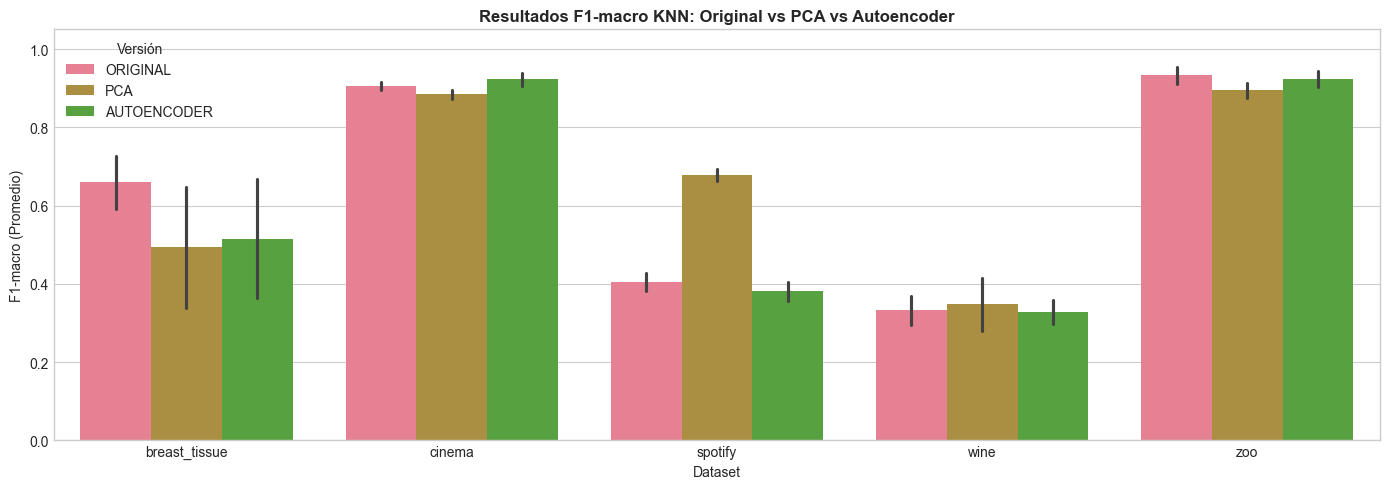

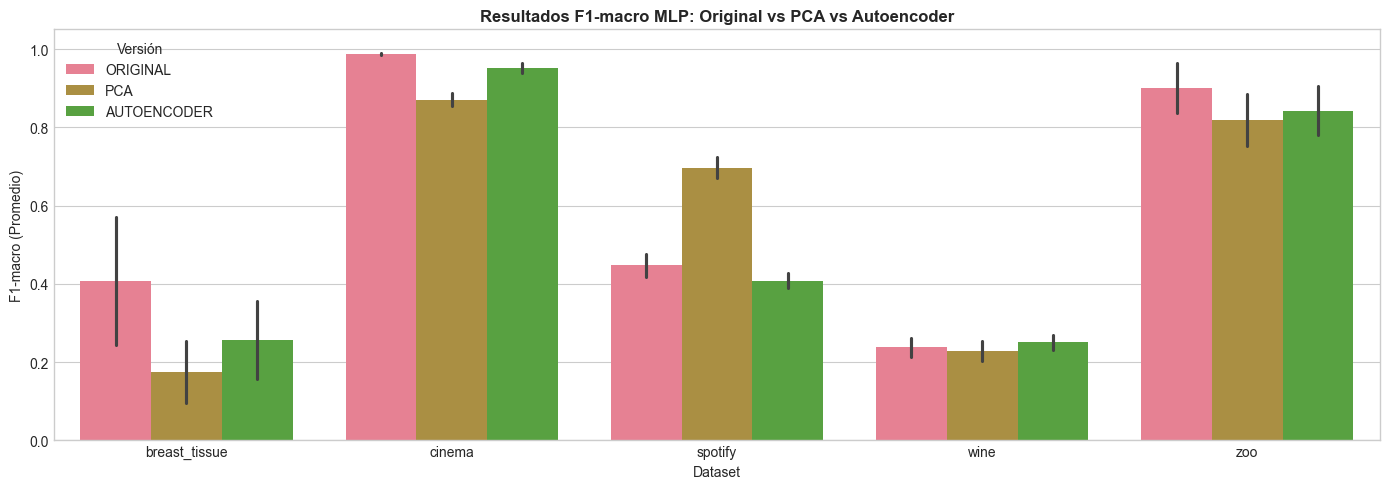

✅ Visualizaciones guardadas: 'knn_comparison_barplot.png', 'mlp_comparison_barplot.png'


In [33]:
# ============================================================================
# 10. VISUALIZACIÓN DE RESULTADOS
# ============================================================================

# Configurar estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Preparar datos para visualización
plot_data = []
for dataset_name in all_results:
    for version in ['original', 'pca', 'autoencoder']:
        if version not in all_results[dataset_name]:
            continue
        for clf in ['knn', 'mlp']:
            if clf not in all_results[dataset_name][version]:
                continue
            res = all_results[dataset_name][version][clf]
            for fold_idx, f1 in enumerate(res['f1_scores'], 1):
                plot_data.append({
                    'Dataset': dataset_name,
                    'Version': version.upper(),
                    'Classifier': clf.upper(),
                    'Fold': fold_idx,
                    'F1-macro': f1,
                    'Method': f"{version.upper()}\n{clf.upper()}"
                })

df_plot = pd.DataFrame(plot_data)

if not df_plot.empty:
    # Gráfico 1: KNN (Original, PCA, AE) por Dataset - Barplot
    df_knn = df_plot[df_plot['Classifier'] == 'KNN']
    
    plt.figure(figsize=(14, 5))
    # errorbar='sd' muestra la desviación estándar de los folds
    sns.barplot(data=df_knn, x='Dataset', y='F1-macro', hue='Version', errorbar='sd')
    plt.title('Resultados F1-macro KNN: Original vs PCA vs Autoencoder', fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('F1-macro (Promedio)')
    plt.legend(title='Versión')
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig('knn_comparison_barplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Gráfico 2: MLP (Original, PCA, AE) por Dataset - Barplot
    df_mlp = df_plot[df_plot['Classifier'] == 'MLP']
    
    plt.figure(figsize=(14, 5))
    sns.barplot(data=df_mlp, x='Dataset', y='F1-macro', hue='Version', errorbar='sd')
    plt.title('Resultados F1-macro MLP: Original vs PCA vs Autoencoder', fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('F1-macro (Promedio)')
    plt.legend(title='Versión')
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig('mlp_comparison_barplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizaciones guardadas: 'knn_comparison_barplot.png', 'mlp_comparison_barplot.png'")
else:
    print("⚠️ No hay datos suficientes para generar visualizaciones")

## 11. Matriz Completa de Comparación Detallada

Matriz exhaustiva mostrando todos los resultados F1 por fold para cada combinación de:
- Dataset
- Versión (Original, PCA, Autoencoder)
- Clasificador (k-NN, MLP)

In [27]:
# ============================================================================
# 11. MATRIZ COMPLETA DE COMPARACIÓN DETALLADA
# ============================================================================

print("=" * 120)
print("MATRIZ COMPLETA DE RESULTADOS F1-MACRO POR FOLD")
print("=" * 120)

# Construir matriz exhaustiva
full_comparison_rows = []

for dataset_name in all_results:
    for fold_idx in range(N_SPLITS):
        row = {
            'Dataset': dataset_name,
            'Fold': f'F{fold_idx + 1}'
        }
        
        for version in ['original', 'pca', 'autoencoder']:
            if version not in all_results[dataset_name]:
                continue
            for clf in ['knn', 'mlp']:
                if clf not in all_results[dataset_name][version]:
                    continue
                col_name = f"{version}_{clf}"
                f1_scores = all_results[dataset_name][version][clf]['f1_scores']
                if fold_idx < len(f1_scores):
                    row[col_name] = f"{f1_scores[fold_idx]:.4f}"
        
        full_comparison_rows.append(row)

df_full = pd.DataFrame(full_comparison_rows)

# Ordenar columnas
base_cols = ['Dataset', 'Fold']
metric_cols = [col for col in df_full.columns if col not in base_cols]
metric_cols_sorted = sorted(metric_cols, key=lambda x: (
    0 if 'original' in x else (1 if 'pca' in x else 2),
    0 if 'knn' in x else 1
))
df_full = df_full[base_cols + metric_cols_sorted]

print("\n📊 Tabla de Resultados F1-macro por Fold:\n")
print(df_full.to_string(index=False))

# Calcular y mostrar estadísticas por método
print("\n" + "=" * 120)
print("📈 ESTADÍSTICAS AGREGADAS POR MÉTODO")
print("=" * 120)

stats_rows = []
for col in metric_cols_sorted:
    values = pd.to_numeric(df_full[col], errors='coerce').dropna()
    if len(values) > 0:
        stats_rows.append({
            'Método': col,
            'Media': f"{values.mean():.4f}",
            'Std': f"{values.std():.4f}",
            'Min': f"{values.min():.4f}",
            'Max': f"{values.max():.4f}",
            'Mediana': f"{values.median():.4f}"
        })

df_stats = pd.DataFrame(stats_rows)
print("\n" + df_stats.to_string(index=False))
print("\n" + "=" * 120)

MATRIZ COMPLETA DE RESULTADOS F1-MACRO POR FOLD

📊 Tabla de Resultados F1-macro por Fold:

      Dataset Fold original_knn original_mlp pca_knn pca_mlp autoencoder_knn autoencoder_mlp
breast_tissue   F1       0.6636       0.4162  0.3801  0.1879          0.4379          0.3096
breast_tissue   F2       0.6393       0.2750  0.4984  0.0741          0.6005          0.3879
breast_tissue   F3       0.7722       0.6750  0.6440  0.1326          0.3384          0.1270
breast_tissue   F4       0.5996       0.3889  0.3008  0.1895          0.7315          0.2035
breast_tissue   F5       0.6224       0.2778  0.6456  0.2897          0.4694          0.2522
       cinema   F1       0.9139       0.9867  0.8839  0.8643          0.9327          0.9479
       cinema   F2       0.9123       0.9900  0.8731  0.8719          0.9285          0.9549
       cinema   F3       0.9076       0.9883  0.8891  0.8700          0.9404          0.9684
       cinema   F4       0.9072       0.9867  0.9005  0.8961          0.

## 12. Conclusiones y Exportación de Resultados

In [28]:
# ============================================================================
# 12. CONCLUSIONES Y EXPORTACIÓN
# ============================================================================

print("=" * 100)
print("📋 CONCLUSIONES DEL ANÁLISIS")
print("=" * 100)

# Análisis de resultados
print("\n🔍 ANÁLISIS DE RENDIMIENTO:")
print("-" * 60)

# Encontrar mejor método global
best_methods = {}
for dataset_name in all_results:
    best_f1 = -1
    best_method = None
    for version in all_results[dataset_name]:
        for clf in all_results[dataset_name][version]:
            f1 = all_results[dataset_name][version][clf]['mean_f1']
            if f1 > best_f1:
                best_f1 = f1
                best_method = f"{version}_{clf}"
    best_methods[dataset_name] = (best_method, best_f1)
    print(f"   {dataset_name}: Mejor método = {best_method} (F1 = {best_f1:.4f})")

# Análisis de Wilcoxon
print("\n📊 RESUMEN DE TESTS DE WILCOXON:")
print("-" * 60)
significant_count = sum(1 for r in wilcoxon_results if r['significant'] == True)
total_tests = sum(1 for r in wilcoxon_results if r['significant'] is not None)

print(f"   Tests realizados: {len(wilcoxon_results)}")
print(f"   Tests con suficientes datos: {total_tests}")
print(f"   Diferencias significativas: {significant_count}/{total_tests}")

for r in wilcoxon_results:
    if r['significant'] == True:
        print(f"\n   ✅ {r['comparison']}")
        print(f"      p-valor: {r['p_value']:.6f}")
        print(f"      {r['interpretation']}")

# Exportar resultados a CSV
print("\n" + "=" * 100)
print("💾 EXPORTACIÓN DE RESULTADOS")
print("=" * 100)

# Guardar tabla de resultados
df_full.to_csv('results_f1_by_fold.csv', index=False)
print("   ✅ Guardado: results_f1_by_fold.csv")

# Guardar resumen
df_summary.to_csv('results_summary.csv', index=False)
print("   ✅ Guardado: results_summary.csv")

# Guardar resultados de Wilcoxon
df_wilcoxon.to_csv('results_wilcoxon.csv', index=False)
print("   ✅ Guardado: results_wilcoxon.csv")

print("\n" + "=" * 100)
print("🎉 PRÁCTICA 3 COMPLETADA")
print("=" * 100)
print("""
Archivos generados:
├── data/pca/          → Datasets reducidos con PCA
├── data/autoencoder/  → Datasets reducidos con Autoencoder
├── results_f1_by_fold.csv       → F1 por fold para cada método
├── results_summary.csv          → Resumen estadístico
├── results_wilcoxon.csv         → Resultados del test de Wilcoxon
├── comparison_boxplots.png      → Visualización de comparación
└── f1_heatmap.png              → Heatmap de rendimiento

Para añadir más datasets de tus compañeros:
1. Coloca el CSV original en: data/original/
2. Ejecuta el notebook nuevamente
3. Se generarán automáticamente las versiones PCA y Autoencoder
""")

📋 CONCLUSIONES DEL ANÁLISIS

🔍 ANÁLISIS DE RENDIMIENTO:
------------------------------------------------------------
   breast_tissue: Mejor método = original_knn (F1 = 0.6594)
   cinema: Mejor método = original_mlp (F1 = 0.9867)
   spotify: Mejor método = pca_mlp (F1 = 0.6961)
   wine: Mejor método = pca_knn (F1 = 0.3476)
   zoo: Mejor método = original_knn (F1 = 0.9324)

📊 RESUMEN DE TESTS DE WILCOXON:
------------------------------------------------------------
   Tests realizados: 6
   Tests con suficientes datos: 6
   Diferencias significativas: 1/6

   ✅ MLP Original vs MLP Autoencoder
      p-valor: 0.009635
      Diferencia significativa. original_mlp es significativamente mejor.

💾 EXPORTACIÓN DE RESULTADOS
   ✅ Guardado: results_f1_by_fold.csv
   ✅ Guardado: results_summary.csv
   ✅ Guardado: results_wilcoxon.csv

🎉 PRÁCTICA 3 COMPLETADA

Archivos generados:
├── data/pca/          → Datasets reducidos con PCA
├── data/autoencoder/  → Datasets reducidos con Autoencoder
├── res